# 预测数值型数据：线性回归

### 1 概述

线性回归是利用数理统计中的回归分析，来确定两种或两种以上变量间相互依赖的定量关系的一种统计分析方法。

* 优点：结果易于理解，计算上不复杂。
* 缺点：对非线性的数据拟合不好。
* 适用数据类型：数值型和标称型数据。

### 2 回归的一般方法

1. 收集数据：采用任意方法收集数据。
2. 准备数据：回归需要数值型数据，标称型数据将被转成二值型数据。
3. 分析数据：绘出数据的可视化二维图将有助于对数据做出理解和分析，在采用缩减法求得新回归系数之后，可以将新拟合线绘在图上作为对比。
4. 训练算法：找到回归系数。
5. 测试算法：使用$R^2$或者预测值和数据的拟合度，来分析模型的效果。
6. 使用算法：使用回归，可以在给定输入的时候预测出一个数值，这是对分类方法的提升，因为这样可以预测连续型数据而不仅仅是离散的类别标签。

#### 2.1 普通最小二乘法

已知给定数据矩阵$X$，将回归系数存放在向量$w$中，则对于预测结果

<center>$y_1=X^Tw$</center>

平方误差为

<center>$Loss = \sum_{i=1}^{m}(y_i-x_{i}^{T}w)^2$</center>

上式用矩阵表示为

<center>$Loss = (y-X^Tw)^T(y-X^Tw)$</center>

对$w$求导，得

<center>$X^T(y-Xw)$</center>

令其为零，解得

<center>$\hat{w}=(X^TX)^{-1}X^Ty$</center>

> 值得注意的是，上述公式中包含$(X^TX)^{-1}$，也就是需要对矩阵求逆，因此这个方程只在逆矩阵存在的时候适用。然而，矩阵的逆可能并不存在，因此必须要在代码中对此作出判断。

#### 2.2 最小二乘法代码实现

In [1]:
from numpy import *

def loadDataSet(fileName):      #general function to parse tab -delimited floats
    numFeat = len(open(fileName).readline().split('\t')) - 1 #get number of fields 
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr =[]
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat,labelMat

def standRegres(xArr,yArr):
    xMat = mat(xArr); yMat = mat(yArr).T
    xTx = xMat.T*xMat
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T*yMat)
    return ws

In [2]:
xArr, yArr = loadDataSet('../data/regressionEx0.txt')

In [3]:
xArr[0:2]

[[1.0, 0.067732], [1.0, 0.42781]]

In [4]:
ws = standRegres(xArr, yArr)

In [5]:
ws

matrix([[3.00774324],
        [1.69532264]])

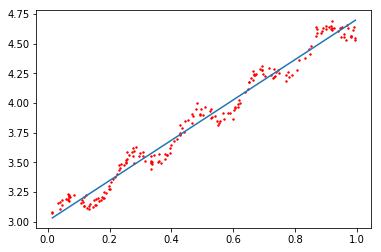

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

xMat = mat(xArr)
yMat = mat(yArr)
yHat = xMat * ws

xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy * ws

ax.scatter(xMat[:, 1].flatten().A[0], yMat.T[:, 0].flatten().A[0], s=2, c='red')
ax.plot(xCopy[:, 1], yHat)

plt.show()

In [7]:
# 计算相关系数来判断模型的好坏

yHat = xMat * ws
corrcoef(yHat.T, yMat)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

### 3 局部加权线性回归

线性回归的一个问题是有可能出现欠拟合现象，因为它求的是具有最小均方误差的无偏估计。有些方法允许在估计中引入一些偏差，从而降低预测的均方误差。

其中的一个方法是局部加权线性回归（Locally Weighted Linear Regression，LWLR）。回归系数$w$的表达式为：

<center>$\hat{w}=(X^TWX)^{-1}X^TWy$</center>

其中$W$是权重矩阵。

In [8]:
def lwlr(testPoint,xArr,yArr,k=1.0):
    xMat = mat(xArr); yMat = mat(yArr).T
    m = shape(xMat)[0]
    weights = mat(eye((m)))
    for j in range(m):                      #next 2 lines create weights matrix
        diffMat = testPoint - xMat[j,:]
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T * (weights * xMat)
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * (weights * yMat))
    return testPoint * ws

def lwlrTest(testArr,xArr,yArr,k=1.0):  #loops over all the data points and applies lwlr to each one
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i],xArr,yArr,k)
    return yHat

In [9]:
yArr[0]

3.176513

In [10]:
lwlr(xArr[0], xArr, yArr, 1.0)

matrix([[3.12204471]])

In [11]:
lwlr(xArr[0], xArr, yArr, 0.001)

matrix([[3.20175729]])

In [12]:
yHat = lwlrTest(xArr, xArr, yArr, 0.01)

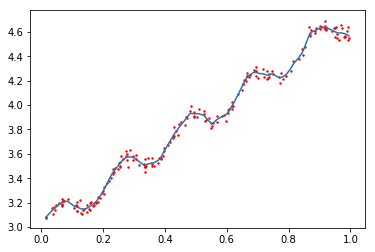

In [13]:
xMat = mat(xArr)
srtInd = xMat[:, 1].argsort(0)
xSort = xMat[srtInd][:, 0, :]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(xMat[:, 1].flatten().A[0], yMat.T[:, 0].flatten().A[0], s=2, c='red')
ax.plot(xSort[:, 1], yHat[srtInd])

plt.show()

> 当k = 1.0时权重很大，如同将所有的数据视为等权重，得出的最佳拟合直线与标准的回归一致。使用k = 0.01得到了非常好的效果，抓住了数据的潜在模式。下图使用k = 0.003纳入了太多的噪声点，拟合的直线与数据点过于贴近。